# Community Detection Algorithms



### Overview


* Community formation is common in all types of networks, and identifying them is essential for evaluating group behavior and emergent phenomena.  
* The general concept in finding communities is that its members will have more relationships within the group than with nodes outside their group. Identifying these related sets reveals: clusters, isolated groups and network structure


### different communitiy detection algorithim groupings
* Triangle Count and Clustering coefficient for overall relationship density (Measuring Algorithims)
* Strongly connected components and weakly connected components for finding connected clusters (Components algorithim)
* Label propagation for quickly inferring groups based on node labels (Label propogation) 
* Louvain Modularity for looking at grouping qualities and heirarchies (Louvanian Modularity) 

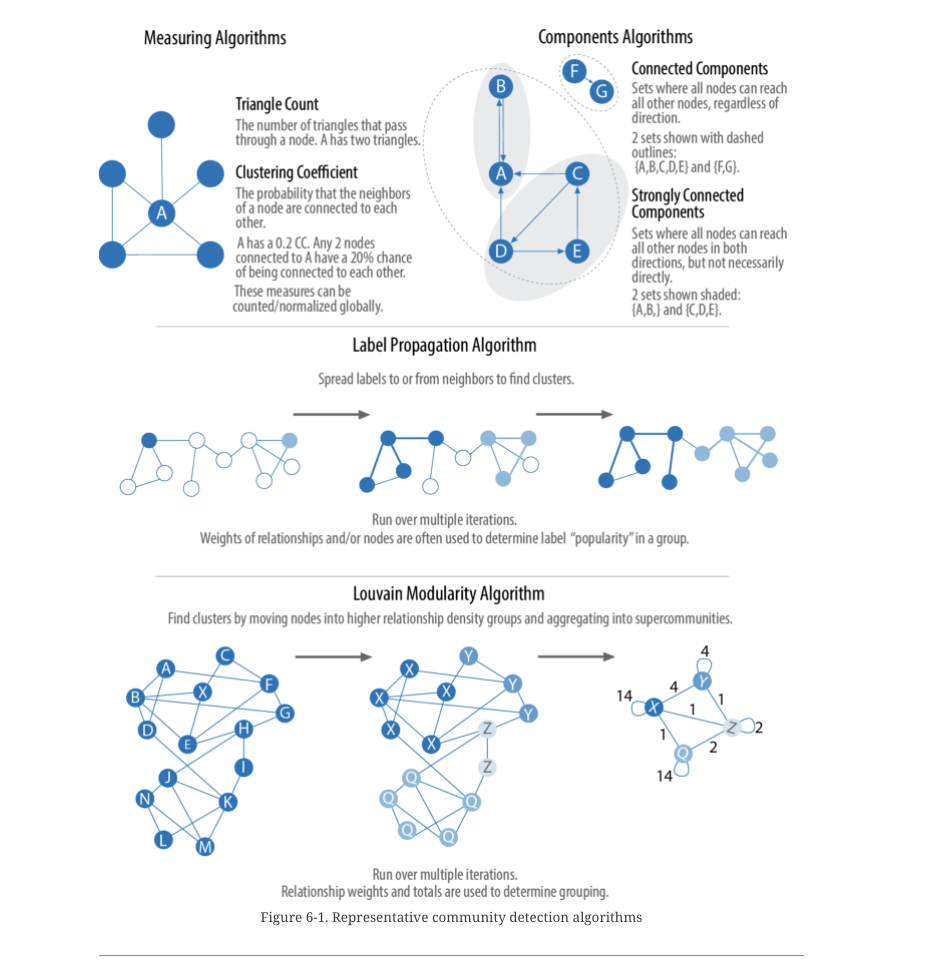



* The terms set, partition, cluster, group and community are all used interchangably
* Community detection also are called clustering or community detection algos



| Algo Type                                  | What it does                                                                                                                   | Example use                                                                                                                        | Spark Example | Neo4j Example |
|--------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| Triangle Count and Clustering Coefficient  | Measures how many nodes form triangles and the  degree to which nodes tend to cluster together                                 | Estimating group stability and whether the network might exhibit "small world" behaviors seen in graphs with tightly knit clusters | Yes           | Yes           |
| Strong Connected Components                | Finds groups where each node is reachable from every other node in the same group, following the direction of relationships    | Making product recomendations based on group affiliation or similar items                                                          | Yes           | Yes           |
| Connected Components                       | Find groups where each node is reachable from every other node in that same group, regardless of direction of relationships    | Performing fast groupings for other algos                                                                                          | Yes           | Yes           |
| Label Propogation                          | Infers Clusters by spreading labels based on neighborhood majorities                                                           | Finding dangerous combinations of co-prescribed drugs                                                                              | Yes           | Y             |
| Louvain Modularity                         | Maximizes the presumed accuracy of groupings by comparing relationship weights and densities to a defined estimate or average  | In fraud analysis, evaluating whetther a group has just a few discrete bad behaviors or is acting as a  fraud ring.                |               |               |
|                                            |                                                                                                                                |                                                                                                                                    |               |               |
|                                            |                                                                                                                                |                                                                                                                                    |               |               |




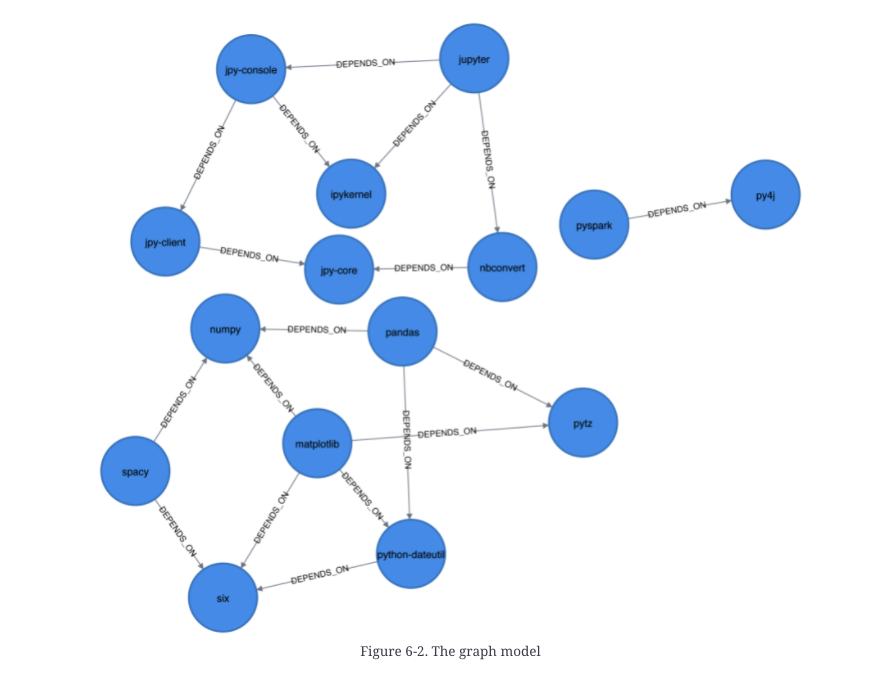


## Trianangle Count and Clustering 

* The triangle Count and Clustering Coefficient algorithims are presented together because they are often used together
* Triangle Count = the number of triangles passing through each node in the graph. 
* A triangle = set of three nodes, where each node has a relationship to the other nodes 
* Triangle count can also be run globally for evaluating a datsaset
* A network with a high number of triangles are more likely to exhibit small-world structures and behaviors
* Goal of clustering coefficient algorithim is to determine how tightly a group is clustered compared to how tightly it could be clustered. 
* The algo uses triangle count in its computation.
* max value of 1 indicates all nodes are connected to every other node
* two clustering coefficients: local & global 


### Local clustering coefficent 

* Local clustering coefficent of a node is the liklihood that its neighbors are also connected. Computation of this score involves triangle counting
* Clustering coefficient of a node can be found by multiplying the number of triangles passing through the node by two and then dividing that by the maximum number of relatonships. 
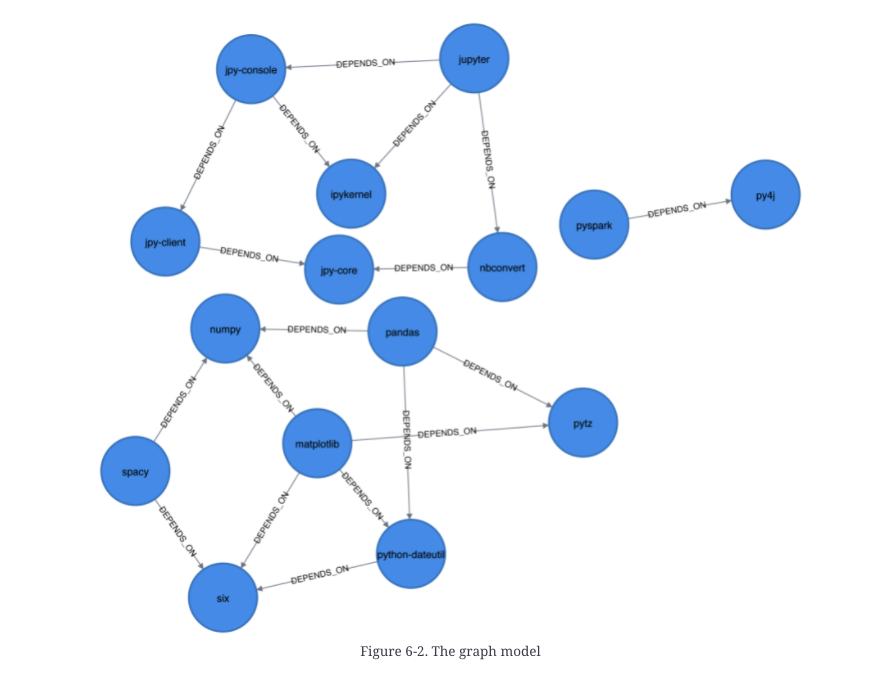

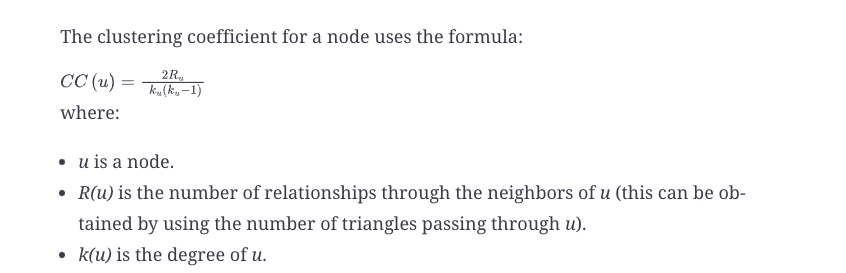



### Global clustering coefficient 


* The global clustering coefficient is the normalized sum of the local clustering coefficient
* Clustering coefficients give us effective means to find obvious groups like cliques



### When should I use Triangle Count and Clustering Coefficient?

* Use triangle Count when you need to determine the stability of a group or as part of calculating other network measures such as the clustering coefficient. Triangle counting is popular in social network analysis, where it is used to detect communities .



### using triangle count with  neo4j 


```

call gds.alpha.triangles({nodeProjection:'Dependency',relationshipProjection: { DEPENDS_ON: { type:'DEPENDS_ON', orientation:'UNDIRECTED'}}}) YIELD nodeA, nodeB, nodeC RETURN gds.util.asNode(nodeA), gds.util.asNode(nodeB), gds.util.asNode(nodeC)


```
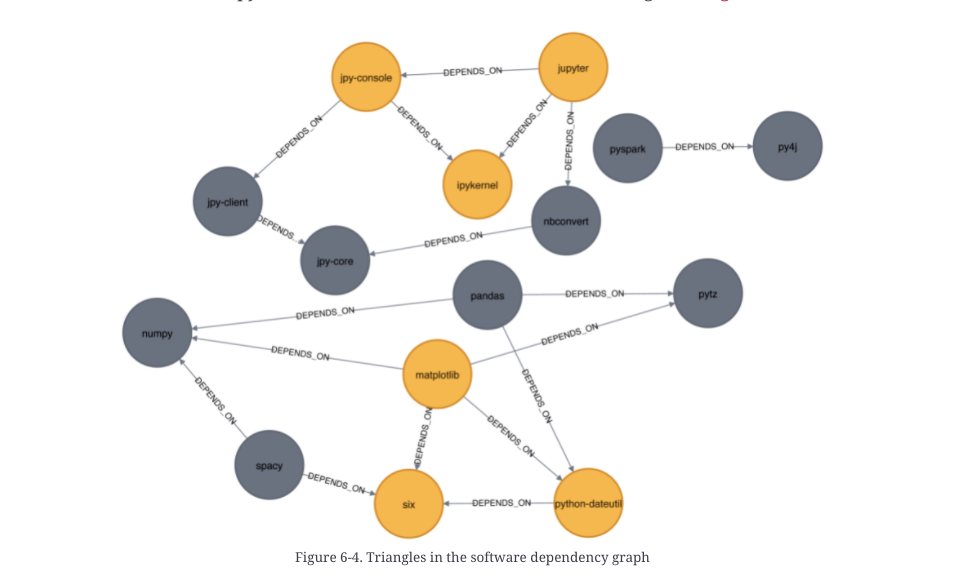




### using local clustering coefficient with neo4j


* We can work out the local clustering coefficient using triangle counting algos
* nodeProjection : Enables the mapping of a specific kinds of nodes into the in-memory graph
* relationshipProjection: Enables the mapping of relaitonship types into the in-memory graph. We can declare one or more relationship types along with direction and properties

* the following query calculates the local clustering coefficient for each node: 



```
CALL gds.localClusteringCoefficient.stream({
  nodeProjection: "Dependency",
  relationshipProjection:  {
    DEPENDS_ON: {
      type: "DEPENDS_ON",
      orientation: "UNDIRECTED"
    }
  }
})
YIELD nodeId, localClusteringCoefficient
WHERE localClusteringCoefficient > 0
RETURN gds.util.asNode(nodeId).id AS library, localClusteringCoefficient
ORDER BY localClusteringCoefficient DESC;


```
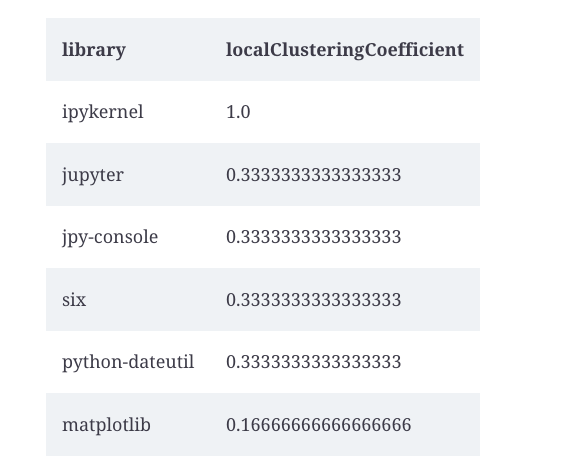

* ipykernal has a score of 1, which means that all of ipykernals neighbors are neighbors of each other. 
* a low coefficient may indicate that a node is a structural hole - a node that is well connected to nodes in different communities that aren't otherwise connected to each other. Another method for finding those bridges ! 





# Strongly connected components


* The strongly connected components (SCC) algo is one fo the earliest graph algos
* SCC finds sets of connected nodes in a directed graph where each node is reachable in both directions from any other node in the same set. Its runtime operations scale well, proportional to the number of nodes. 
* decomposing a graph into SCC is a classic DFS problem. Neo4j uses DFS in it's implementation of SCC


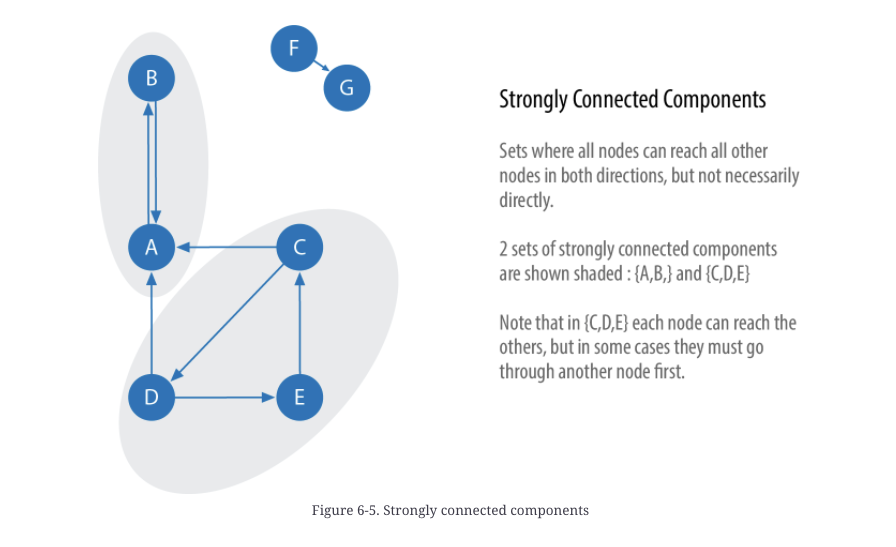



## When should I use strongly connected components?

* use it as an early step in graph analysis to see how a graph is structured or to identify tight clusters that may warrant independent investigation 
* a component that is strongly connected can be used to profile similar behavior or inclinations in a group for applications such as recommendation engines. 
* good for finding processes that might deadlock since they are waiting on other processes.

#### example use cases

* finding the set of firms in which every member directly or indirectly owns shares in every other member
* computing the connectivity of different network configurations when measuring routing performance for multihop wireless network 
* first step for other graph algos. In social networks, we find many SCC groups. In these sets people often have similar preferences. 



# (weakly) Connected Components 


* The connected components algorithim (or weakly connected components) finds sets of connected components in an undirected graph where each node is reachable from any other node in a set
* it's different from SCC algo because it only needs a path to exist between pairs of nodes in one direction
* Remember SCC is bidirectional



### why use weakly connected components

* often used as early analysis of a graph structure, because it scales efficiently, consider the algo for graphs requiring frequent updates. It can quickly show new nodes in common between groups. 
* often good to run weakly connected components to test whether a graph is connected as a prep step for general graph analysis. 

#### example use cases


* Keeping track of clusters of database records, as part of deduplication process. Deduplication is an important task in master data management applications; the approach is described in more detail in "An Efficient Domain Independent Algo for detecting approximately Duplicate Database Records'
* Analyzing citation networks





** all algos up until this point have been deterministic, every time we run them we get the same result, next algos are non-deterministic 













# Label Propagation 


* Label Propagation algorithim (LPA) is a fast algorithim for finding communities in a graph. In LPA, nodes select their group based on their direct neighbors. 
* the main idea is a single label can become dominant in a group of densly connected nodes, but will have trouble crossing a sparsly connected region. 


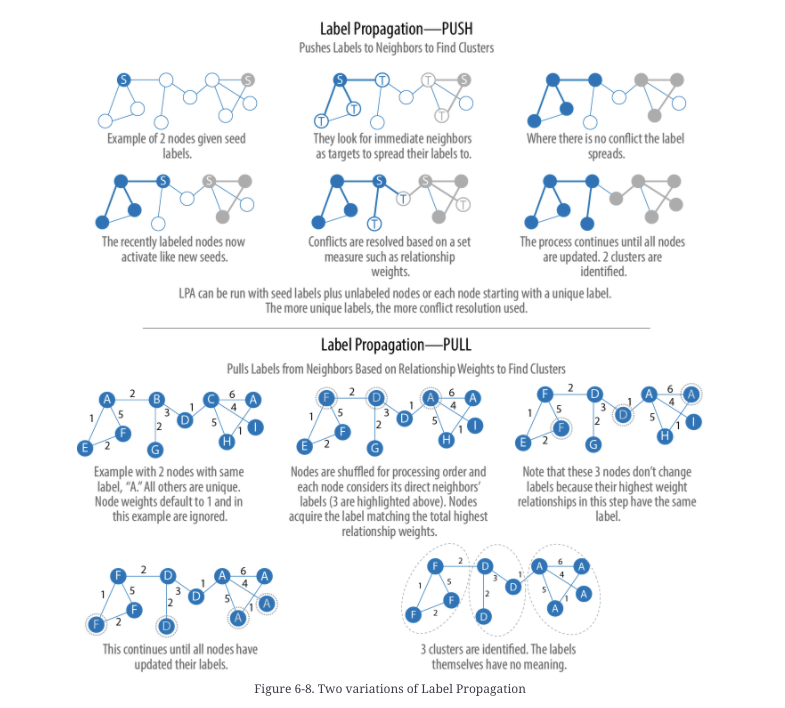


* The steps often sued in label propagation pull methods are

1. Every node is intialized with a unique label, and optionally preliminary 'seed' labels can be used
2. These labels propogate throughout the network
3. At every propogation iteration, each node updates its label to match teh one with the max weight,which is calculated based on the weights of neighbor nodes and their relationships. 
4. LPA reaches a convergence when each node has a majority 



## Semi supervised learning and seed labels


* In contrast to other algos, Label propagation can return different community structures when run multiple times on the same graph
* The order in which LPA evaluates nodes can have an influence on the final communities it returns
* range of solutions is narrowed by preseeding labels. Unlabeled nodes are more likely to adopt the propogated nodes
* This use of Label Propagation can be considered a semi-supervised learning method to find communities. 



## when should I use label propogation?


* Use label propogation in large-scale networks for initial community detection, especially when weights are available. This algorithim can be parrellized and is therefore extremely fast at graph partitioning. 

#### example use cases:

1. Assigning polarity of tweets as part of a semantic analysis. In this scenario, positive and negative seed labels from a classifier are used in combinaton with the Twitter follower graph.
2. Finding potentially dangerous combintions of co-prescribed drugs, based on chemical similarities and side effects. 
3. Inferring dialogue features and user intention for machine learning model.


```


CALL gds.labelPropagation.stream({
  nodeProjection: "Library",
  relationshipProjection: "DEPENDS_ON",
  maxIterations: 10
})
YIELD nodeId, communityId
RETURN communityId AS label,
       collect(gds.util.asNode(nodeId).id) AS libraries
ORDER BY size(libraries) DESC;



```


# Louvain Modularity 


* The Louvain Modularity algorithm finds clusters by comparing community density as it assigns nodes to different groups
* You can think of this as a 'what-if' analysis to try various groupings with the goal of reaching a global optimum 
* Louvain quantifies how well a node is assigned to a group by looking at the density connections within a cluster in comparison to an average or random sample. 



## Quality based grouping vs modularity 


* Modularity is a technique for uncovering communities by partitioning a graph into more coarse-grained modules (or clusters), then measuring the strength of those groupings
* Compares relationship density inside clusters to those of surrounding clusters.
* the measure of the quality of these groupings is called modularity.
* modularity algorithims optimize communities locally and then globally, using multiple iterations to test different groupings and increase coarseness 


### all modularity algos suffer these drawbacks

1. They merge smaller communities into larger ones
2. a pleateau can occur where several paritions options are present within similar modularity, forming local maxima preventing progress. 


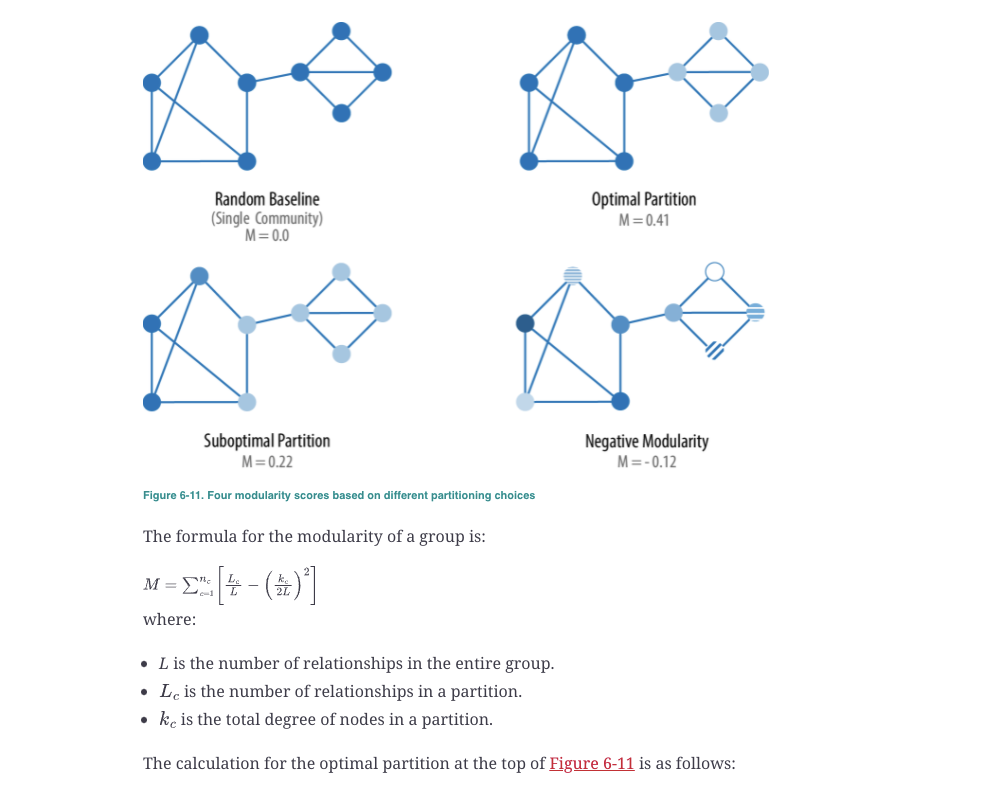
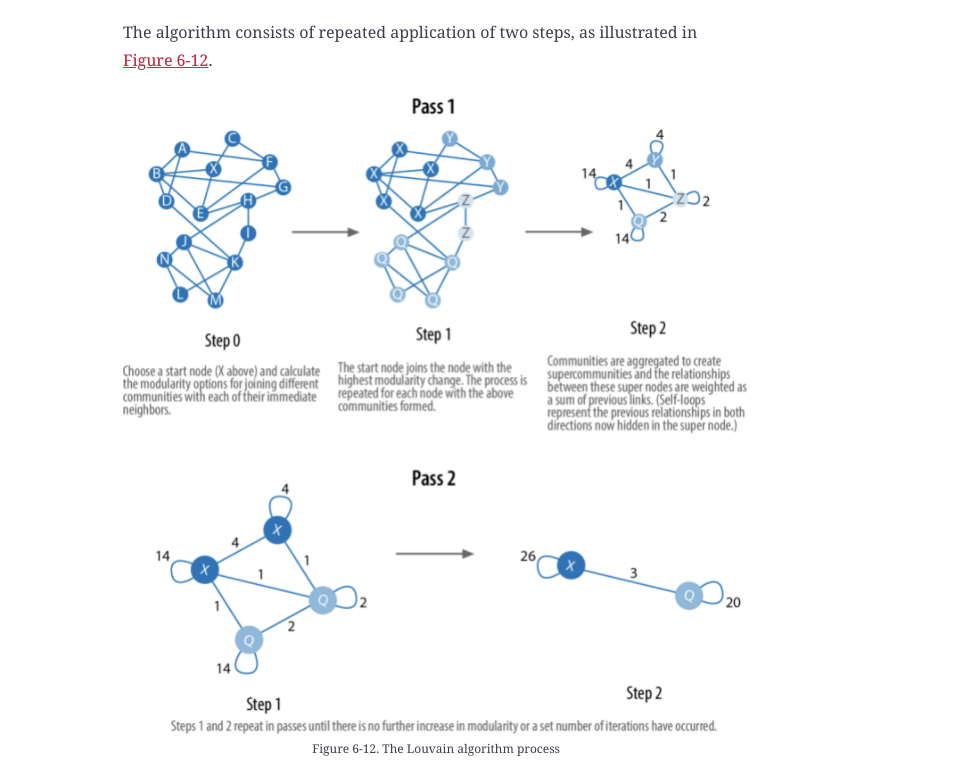


### when should I use Louvain?


* Use Lovain Modulartiy to find communities in vast networks. This applies a heaurstic, as opposed to exact, modularity, which is computationally expensive. 
* basically use it on very large graphs
* helpful for evaluating the structure of complex networks, in particular in uncovering many levels of hierarchies - such as a criminal organization. 

#### example use cases:

* Detecting a cyperattack.
* Extracting topics from online social platforms, based on the co-occurence of terms in documents as part of the topic modeling 







# Validating Communities



* Communiy detection algos generally have the same goal: to identify groups. 
* However these algos begin with  different assumptions, they may uncover different communities. This makes choosing the right algorithim hard
* Most community detection algos do reasonably well when relationship density is high within groups, compared to their surroundings, but real-world networks are often less distinct. We can validate accuracy of communities by comparing our results to benchmarks based on data with known communities. 
